In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from itertools import product
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Task 1

The shallow NN is implemented as a simple script.
Change the file name below this to train on a different dataset.

In [29]:
#dataset prep
file_name = r"datasets/blobs600.csv"
#file_name = r"datasets/circles500.csv"
df = pd.read_csv(file_name)

X = df.iloc[:, :-1].values
Y = df.iloc[:, -1].values.reshape(-1, 1)
print(X.shape, Y.shape)

(600, 3) (600, 1)


Algorithm
- initialize hyperparameters, alpha(learning rate), w(weight) in the shape of input features, and b(bias) 
- initliaze counter iteration(to keep of the current iteration), J_running (loss of current iteration), J_prev, stopping (control variable for while)

Loop
- sample a point x and its y
- compute z, w Transpose * x + b, apply activation function, compute loss between y and y_cap
- computer dz = y_cap - y, compute weight gradient x . dz, bias gradient dz
- update weights w = w - alpha * weight gradient, bias b = b - alpha * bias gradient
- update counter iteration, set stopping to True if more than max iterations
- calculate loss, take difference between loss of prev iteration, stop if less than threshold

- set weights after training is finished

In [30]:
#helper functions. these will be used in the main training loop and prediction of the model

#Using sigmoid activation function
def sigmoid(t):
    return 1/(1 + np.exp(-t))

#Using binary cross entropy loss
def loss_function(y, y_cap):
    #to remove infinite values from log, clip y_cap to be between epsilon and 1-epsilon 
    epsilon = np.finfo(float).eps
    y_cap = np.clip(y_cap, epsilon, 1 - epsilon)
    #loss of a single data ppoint
    return -(y * np.log( y_cap ) + (1 - y) * np.log(1 - y_cap ) ) 


In [31]:
#hyperparameters

#alpha is the learning rate, w is the weights of the model, b is the bias
alpha = 0.01
w = np.array(X.shape[1] * [.5]).reshape(-1, 1)
b = 0.5
#stopping is a control variable for the training loop, 
#J_running is the current loss, J_prev is the previous loss, iteration is the current iteration number, max_iters is the maximum number of iterations allowed 
stopping = False; J_running = 0; J_prev = 0; iteration = 0; max_iters = 100000
#convergence threshold for running loss difference
threshold = 1e-6
#Checking convergence every N iterations
N = 1000
m = X.shape[0]
n = X.shape[1]

In [32]:
#refactor and use functions for forward propagation ?

while not stopping:
    i = np.random.randint(0,m)
    x = X[i].reshape(-1,1)
    y = Y[i,0]

    #forward propagation
    z = (w.T @ x + b).item() #calculating the probabilty of class 1, using item to get a scalar from a 1x1 array
    y_hat = sigmoid(z) #activation function to get predicted class
    #calculating J_current from y, y_hat
    J_current = float(loss_function(y, y_hat))
    #gradient descent 
    dz = (y_hat - y)

    #looping over j elements of w to calculate partial derivative of the loss with respect to each wt
    delta_w = np.zeros_like(w)
    for j in range(n):
        delta_w[j,0] = x[j,0] * dz

    #calculating delta_b
    delta_b = dz
    #looping again over j elemets of w: w_j -= alpha * partial derivative
    for j in range(n) :
        w[j,0] = w[j, 0] - alpha* delta_w[j, 0]

    b -= alpha*delta_b
    #we need to check the stopping criteria 
    iteration +=1
    J_running += J_current

    if iteration > max_iters:
        #failing to converge
        stopping = True 

    if (iteration % N ) == 0:
        #comparing J_running with J_running_prev
        #if its less than threshold we will put stopping = true 
        if abs(J_running - J_prev) < threshold :
            stopping = True 

        J_prev = J_running
        J_running = 0
        #predictions and training accuracy
        Y_prob = sigmoid(X @ w + b)
        Y_pred = (Y_prob >= 0.5).astype(int)
        acc = np.mean(Y_pred == Y)
        print("Training accuracy:", float(acc))

Training accuracy: 0.9966666666666667
Training accuracy: 0.9966666666666667
Training accuracy: 0.9966666666666667
Training accuracy: 0.9966666666666667
Training accuracy: 0.9966666666666667
Training accuracy: 0.9966666666666667
Training accuracy: 0.995
Training accuracy: 0.995
Training accuracy: 0.995
Training accuracy: 0.995
Training accuracy: 0.995
Training accuracy: 0.9966666666666667
Training accuracy: 0.9966666666666667
Training accuracy: 0.9966666666666667
Training accuracy: 0.9966666666666667
Training accuracy: 0.9966666666666667
Training accuracy: 0.9966666666666667
Training accuracy: 0.9966666666666667
Training accuracy: 0.995
Training accuracy: 0.995
Training accuracy: 0.9966666666666667
Training accuracy: 0.9966666666666667
Training accuracy: 0.9966666666666667
Training accuracy: 0.9966666666666667
Training accuracy: 0.995
Training accuracy: 0.995
Training accuracy: 0.9966666666666667
Training accuracy: 0.995
Training accuracy: 0.995
Training accuracy: 0.995
Training accurac

# Task 2

The NN above is refactored as a scikit-learn style class.
Run fit() to train, and predict() to predict(), and score() to get an accuracy score on a given set 

In [33]:
class LogisticRegressor:
    def __init__(self, alpha=0.01, max_iters=100000, threshold=1e-6, N=1000, random_state=42):
        self.alpha = alpha
        self.max_iters = max_iters
        self.threshold = threshold
        self.N = N
        self.random_state = random_state
        self.trained = False #to be used in predict
        np.random.seed(self.random_state)

    def sigmoid(self, t):
        return 1/(1 + np.exp(-t))
    
    def loss_function(self, y, y_cap):
        epsilon = np.finfo(float).eps
        y_cap = np.clip(y_cap, epsilon, 1 - epsilon)
        return -(y * np.log(y_cap) + (1 - y) * np.log(1 - y_cap))
    
    def fit(self, X, Y):

        X = np.array(X)
        Y = np.array(Y).reshape(-1, 1)

        m = X.shape[0]
        n = X.shape[1]

        w = np.array(X.shape[1] * [.5]).reshape(-1, 1)
        b = 0.5

        stopping = False; J_running = 0; J_prev = 0; iteration = 0; acc = 0
        

        while not stopping:
            i = np.random.randint(0,m)
            x = X[i].reshape(-1,1)
            y = Y[i,0]

            #forward propagation
            z = (w.T @ x + b).item()
            y_hat = self.sigmoid(z)
            #calculating J_current from y, y_hat
            J_current = float(self.loss_function(y, y_hat))
            #gradient descent 
            dz = (y_hat - y)

            #looping over j elements of w to calculate partial derivative of the loss with respect to each wt
            delta_w = np.zeros_like(w)
            for j in range(n):
                delta_w[j,0] = x[j,0] * dz

            #calculating delta_b
            delta_b = dz
            #looping again over j elemets of w: w_j -= alpha * partial derivative
            for j in range(n) :
                w[j,0] = w[j, 0] - self.alpha* delta_w[j, 0]

            b -= self.alpha*delta_b
            #we need to check the stopping criteria 
            iteration +=1
            J_running += J_current

            if iteration > self.max_iters:
                #failing to converge
                stopping = True 

            if (iteration % self.N ) == 0:
                #comparing J_running with J_running_prev
                #if its less than threshold we will put stopping = true 
                if abs(J_running - J_prev) < self.threshold :
                    stopping = True 

                J_prev = J_running
                J_running = 0
                #predictions and training accuracy
                Y_prob = self.sigmoid(X @ w + b)
                Y_pred = (Y_prob >= 0.5).astype(int)
                acc = np.mean(Y_pred == Y)
                print("Training accuracy:", float(acc))
        #set weights here
        self.w = w
        self.b = b
        self.accuracy = acc
        self.trained = True

    def predict(self,x):
        if (self.trained == False):
            raise ValueError("Not trained uyet!")
        
        y_prob = self.sigmoid(x @ self.w + self.b)
        Y_pred = (y_prob >= 0.5).astype(int)
        return Y_pred
    
    def score(self, x_test, y_test):
        if (self.trained == False):
            raise ValueError("Not trained uyet!")        
        
        y_pred = self.predict(x_test)
        correct = 0
        size = len(y_test)

        for i in range(size):
            if (y_pred[i]==y_test[i]):
                correct+=1

        return correct/size
    

## Dataset 1 - Blobs 3D

In [34]:
# Use pandas to read the CSV file as a dataframe
file_name = r"datasets/blobs600.csv"
df1 = pd.read_csv(file_name)

# The y values are those labelled 'Class': extract their values
y1 = df1['Class'].values
# The x values are all other columns
del df1['Class']   # drop the 'Class' column from the dataframe
X1 = df1.values     # convert the remaining columns to a numpy array
# Check its dimensions
print(f"The dimensions of the dataset are: {np.shape(X1)}")

The dimensions of the dataset are: (600, 3)


In [35]:
np.random.seed(42)
from sklearn.model_selection import train_test_split 
X1_train, X1_temp, y1_train, y1_temp = train_test_split(X1,y1,test_size = 0.30,random_state = 42, shuffle = True)
X1_val, X1_test, y1_val, y1_test = train_test_split(X1_temp,y1_temp,test_size = 0.50,random_state = 42)


In [36]:

#validation tests
best_model = None
best_score = 0

for alpha in [0.01, 0.1, 0.5, 1, 2, 10]:
    lr = LogisticRegressor(alpha=alpha, max_iters=10000, N=100, random_state=42)
    lr.fit(X1_train, y1_train)
    score = lr.score(X1_val, y1_val)
    print(" alpha =", alpha, ":","val score =", score)
    if score > best_score:
        best_score = score
        best_model = lr

Training accuracy: 0.9880952380952381
Training accuracy: 0.9976190476190476
Training accuracy: 0.9976190476190476
Training accuracy: 0.9976190476190476
Training accuracy: 0.9976190476190476
Training accuracy: 0.9976190476190476
Training accuracy: 0.9976190476190476
Training accuracy: 0.9976190476190476
Training accuracy: 0.9976190476190476
Training accuracy: 0.9976190476190476
Training accuracy: 0.9976190476190476
Training accuracy: 0.9976190476190476
Training accuracy: 0.9976190476190476
Training accuracy: 0.9976190476190476
Training accuracy: 0.9976190476190476
Training accuracy: 0.9976190476190476
Training accuracy: 0.9976190476190476
Training accuracy: 0.9976190476190476
Training accuracy: 0.9976190476190476
Training accuracy: 0.9976190476190476
Training accuracy: 0.9976190476190476
Training accuracy: 0.9976190476190476
Training accuracy: 0.9976190476190476
Training accuracy: 0.9976190476190476
Training accuracy: 0.9976190476190476
Training accuracy: 0.9976190476190476
Training acc

In [37]:
print("Best alpha:", best_model.alpha, ",val score:", best_score, ",test score:", best_model.score(X1_test, y1_test))


Best alpha: 0.01 ,val score: 0.9888888888888889 ,test score: 1.0


best alpha would be .01 but im using alpha=5 to demonstrate a graph with a misclassificationm, otherwise it gives 100 percent test accuracy 
and graph shows no missclassification points

In [38]:
lr1 = LogisticRegressor(alpha = 5, max_iters = 10000, threshold = 1e-6, N=100, random_state=50)
lr1.fit(X1_train, y1_train)

Training accuracy: 0.9976190476190476
Training accuracy: 0.9952380952380953
Training accuracy: 0.9738095238095238
Training accuracy: 0.9738095238095238
Training accuracy: 0.9880952380952381
Training accuracy: 0.9952380952380953
Training accuracy: 0.9952380952380953
Training accuracy: 0.9952380952380953
Training accuracy: 0.9952380952380953
Training accuracy: 0.9976190476190476
Training accuracy: 0.9976190476190476
Training accuracy: 0.9976190476190476
Training accuracy: 0.9976190476190476
Training accuracy: 0.9976190476190476
Training accuracy: 0.9976190476190476
Training accuracy: 0.9976190476190476
Training accuracy: 0.9976190476190476
Training accuracy: 0.9976190476190476
Training accuracy: 0.9976190476190476
Training accuracy: 0.9976190476190476
Training accuracy: 0.9976190476190476
Training accuracy: 0.9976190476190476
Training accuracy: 0.9976190476190476
Training accuracy: 0.9976190476190476
Training accuracy: 0.9976190476190476
Training accuracy: 0.9976190476190476
Training acc

In [39]:
lr1.score(X1_test,y1_test)

0.9888888888888889

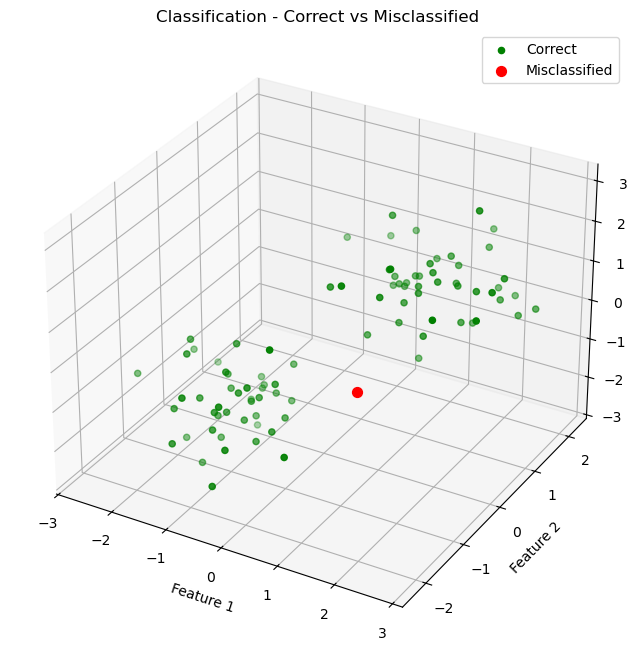

In [40]:
#plotting the misclassified points here
y_pred = lr1.predict(X1_test)
y_pred = y_pred.ravel()
correct = (y_pred == y1_test)
n_mis = int(np.sum(~correct))

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection="3d")

#correct preds
ax.scatter(
    X1_test[correct,0],
    X1_test[correct,1],
    X1_test[correct,2],
    c="green",
    label="Correct",
    s=20
)

#incorrect preds
if n_mis > 0:
    ax.scatter(
        X1_test[~correct,0],
        X1_test[~correct,1],
        X1_test[~correct,2],
        c="red",
        label="Misclassified",
        #depthshade=False,
        s=50
    )

ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_zlabel("Feature 3")
ax.set_title("Classification - Correct vs Misclassified")
ax.legend()

plt.show()


The dataset was linearly seperable so training the model has a very high accuracy on this dataset. We increased alpha to 5 (even though we got the best scores when it was 0.01) to show example of misclassifications in the graph.

## Dataset 2 - Circles 2d

In [41]:
# Use pandas to read the CSV file as a dataframe
file_name = r"datasets/circles500.csv"
df2 = pd.read_csv(file_name)

# The y values are those labelled 'Class': extract their values
y2 = df2['Class'].values

# The x values are all other columns
del df2['Class']   # drop the 'Class' column from the dataframe
X2 = df2.values     # convert the remaining columns to a numpy array
# Check its dimensions

print(f"The dimensions of Dataset 2 are: {np.shape(X2)}")

The dimensions of Dataset 2 are: (500, 2)


In [42]:
# Some examples of working with the data, to look at rows/columns
print ("len(X2):", len(X2))            # outer array: one per sample
print ("len(X2[0]):", len(X2[0]))      # each inner array is the attributes of one sample
print ("len(X2[:,0]):", len(X2[:,0]))  # select column 0 from array

# np.shape returns all dimensions of the array
(nsamples, nattribs) = np.shape(X2)
print ("X2: nsamples =", nsamples, ", nattribs =", nattribs)

# Now example the y vector (1D array)
print ("len(y2)", len(y2))
print ("np.shape(y2):", np.shape(y2))

# You can transpose the y data using 'reshape'
yt = np.reshape(y2, (len(y2),1))  
print ("np.shape(yt):", np.shape(yt))
(nsamples, nattribs) = np.shape(yt)
print ("y2 transpose: nsamples =", nsamples, ", nattribs =", nattribs)

len(X2): 500
len(X2[0]): 2
len(X2[:,0]): 500
X2: nsamples = 500 , nattribs = 2
len(y2) 500
np.shape(y2): (500,)
np.shape(yt): (500, 1)
y2 transpose: nsamples = 500 , nattribs = 1


In [43]:
from sklearn.model_selection import train_test_split 
X2_train, X2_temp, y2_train, y2_temp = train_test_split(X2,y2,test_size = 0.30,random_state = 42, shuffle = True)
X2_val, X2_test, y2_val, y2_test = train_test_split(X2_temp,y2_temp,test_size = 0.50,random_state = 42)

print("Dataset2 splits:")
print("Train:", X2_train.shape)
print("Validation:",X2_val.shape)
print("Test:",X2_test.shape)

Dataset2 splits:
Train: (350, 2)
Validation: (75, 2)
Test: (75, 2)


In [44]:
import sys
import os
sys.path.append(os.path.abspath(".."))
#from task1.LogisticRegressor import LogisticRegressor

#Creating model instance
model = LogisticRegressor(alpha = 1, max_iters = 100000, threshold = 1e-6, N=1000, random_state=42)

#reshaping labels
y2_train_col = y2_train.reshape(-1,1)
y2_val_col = y2_val.reshape(-1,1)
y2_test_col = y2_test.reshape(-1,1)

model.fit(X2_train, y2_train_col)

train_acc = model.score(X2_train, y2_train_col)
val_acc = model.score(X2_val, y2_val_col)
test_acc = model.score(X2_test, y2_test_col)

Training accuracy: 0.49714285714285716
Training accuracy: 0.45714285714285713
Training accuracy: 0.4857142857142857
Training accuracy: 0.4857142857142857
Training accuracy: 0.5142857142857142
Training accuracy: 0.5142857142857142
Training accuracy: 0.5971428571428572
Training accuracy: 0.37142857142857144
Training accuracy: 0.6057142857142858
Training accuracy: 0.5514285714285714
Training accuracy: 0.6228571428571429
Training accuracy: 0.5914285714285714
Training accuracy: 0.5142857142857142
Training accuracy: 0.39714285714285713
Training accuracy: 0.6428571428571429
Training accuracy: 0.5771428571428572
Training accuracy: 0.5142857142857142
Training accuracy: 0.4857142857142857
Training accuracy: 0.5457142857142857
Training accuracy: 0.5142857142857142
Training accuracy: 0.5057142857142857
Training accuracy: 0.5142857142857142
Training accuracy: 0.5285714285714286
Training accuracy: 0.3914285714285714
Training accuracy: 0.5142857142857142
Training accuracy: 0.4857142857142857
Training

In [45]:
print("Dataset2 scores")
print("Training accuracy:", train_acc)
print("Validation accuracy:", val_acc)
print("Test accuracy:", test_acc)
y2_pred_test = model.predict(X2_test)
y_pred_flat = y2_pred_test.ravel()

Dataset2 scores
Training accuracy: 0.56
Validation accuracy: 0.4666666666666667
Test accuracy: 0.6266666666666667


This model doesnt seem to be performing well with this dataset. we'll try and visualize how the model tries to seperates this datasset

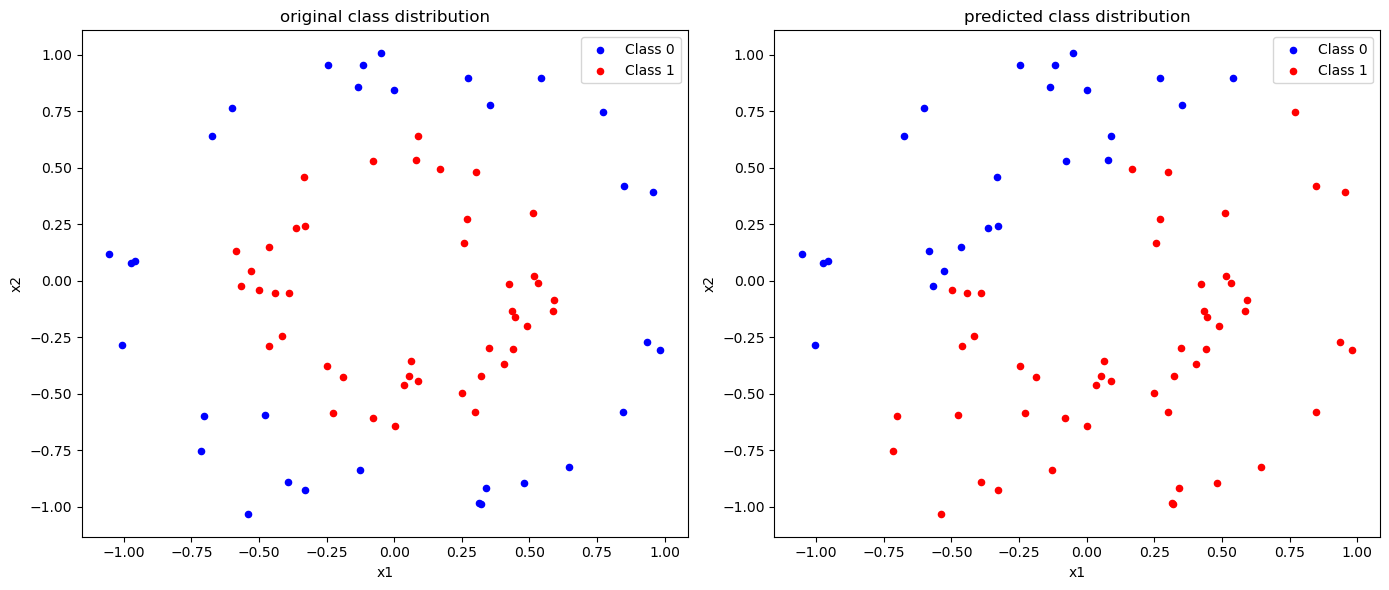

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(14,6))  # 1 row, 2 columns

#shows classes in the original test set
class0_orig = np.where( y2_test == 0 )
class1_orig = np.where( y2_test == 1)

axes[0].scatter(X2_test[class0_orig, 0 ], X2_test[class0_orig, 1 ], color='blue', s=20, label='Class 0')
axes[0].scatter(X2_test[class1_orig, 0 ], X2_test[class1_orig, 1 ], color='red', s=20, label='Class 1')
axes[0].set_title("original class distribution")
axes[0].set_xlabel("x1")
axes[0].set_ylabel("x2")
axes[0].legend()

#shows the same set, but how the model classified it as
class0_pred = np.where(y_pred_flat == 0)
class1_pred = np.where(y_pred_flat == 1)
axes[1].scatter(X2_test[class0_pred, 0 ], X2_test[class0_pred, 1 ], color='blue', s=20, label='Class 0')
axes[1].scatter(X2_test[class1_pred, 0 ], X2_test[class1_pred, 1 ], color='red', s=20, label='Class 1')
axes[1].set_title("predicted class distribution")
axes[1].set_xlabel("x1")
axes[1].set_ylabel("x2")
axes[1].legend()

plt.tight_layout()
plt.show()


Originally in the dataset, the two classes are concentric circles that are not linearly separable. So its not surprising when the linear model tries and fails to do separate them. In the predicted subgraph you can see the bounday where the model tried to separate the two classes.

Using a confusion matrix to analyze which classes it is missclassifying. Most of class 1 is being classified right, but 0 is being misclassified. Rather, the model seems to predict most of the test data as class 1. This is evidenced by looking at where the model tried to create the boundary in the graph above, there are more points in class 1. 

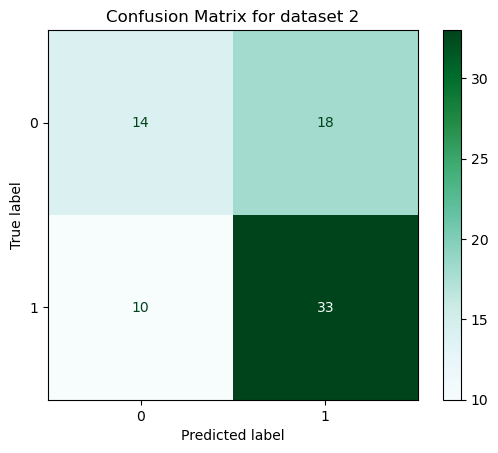

In [47]:
cm = confusion_matrix(y2_test, y2_pred_test)

disp = ConfusionMatrixDisplay( confusion_matrix=cm , display_labels=[0,1] )
disp.plot( cmap=plt.cm.BuGn)
plt.title("Confusion Matrix for dataset 2")
plt.show()


# Task 3

This is a shallow neural network, with a single hidden layer, the size of which can be adjusted with the 'hidden_layer_size'. Ther are two sets of weights and biases. 
Inputs are numpy arrays, and calculations are vectorized. 

Algorithm
- initialize weights to small values and biases to zeros
- loop until maxiterations or convergence
    - forward pass
        - calculate first activation layer, then the output
        - calculate loss
    - back propagation
        - compute output error
        - compute gradient for w2
        - computer hidden layer error
        - compute gradient for w1
    - update weights


In [48]:
class LogisticRegressor:
    def __init__(self, alpha=0.01, max_iters=100000, threshold=1e-6, N=1000, hidden_layer_size=3, seed=42):
        self.alpha = alpha
        self.max_iters = max_iters
        self.threshold = threshold
        self.N = N #not used 
        self.hidden_layer_size = hidden_layer_size # not sure what to do with this. 
        self.seed = seed
        self.loss_history = []
        self.accuracy_history = []
        self.trained = False #to be used in predict

    def sigmoid(self, t):
        return 1/(1 + np.exp(-t))

    #def relu(self, z):
        #return np.maximum(0, z)

    #def relu_derivative(self, z):
        #return (z > 0).astype(float)
    
    def loss_function(self, y, y_cap):
        epsilon = np.finfo(float).eps
        y_cap = np.clip(y_cap, epsilon, 1 - epsilon)
        return -(y * np.log(y_cap) + (1 - y) * np.log(1 - y_cap))
    
    def fit(self, X, Y):
        np.random.seed(self.seed)
        self.loss_history = []
        self.accuracy_history = []

        m = X.shape[0] # number of samples
        n = X.shape[1] # number of features

        #init weights and bias
        W1 = np.random.randn(self.hidden_layer_size,n) * 0.01 #random values with mean=0, stdev=0.01 ?
        b1 = np.zeros((self.hidden_layer_size,1))

        W2 = np. random.randn(1,self.hidden_layer_size) * 0.01 
        b2 = np.zeros((1, 1))

        X = np.array(X)
        Y = np.array(Y).reshape(-1, 1) #reshaping so that Y is a column vector, to be used in matrix mulitplication
        


        stopping = False; loss_prev = 0; iteration = 0; acc = 0
        

        while not stopping:
            #select random data point
            
            i = np.random.choice(np.arange(m))  # pick a random index
            x = X[i].reshape(-1,1)
            y = Y[i, 0]

            #forward pass
            a1 = self.sigmoid(W1 @ x + b1)
            y_cap = (self.sigmoid(W2 @ a1 + b2)).item()
            
            
            loss = self.loss_function(y, y_cap)
            self.loss_history.append(float(loss))
            
            #back propagation
            #output layer
            deltaz = y_cap - y
            delW2 = deltaz * a1.T
            delb2 = deltaz
            #hidden layer
            deltaz1 = (W2.T * deltaz) * (a1 * (1 - a1))
            delW1 = deltaz1 @ x.T    # gradient of hidden weights
            delb1 = deltaz1           # gradient of hidden biases

            #stochatic gradient descent
            W1 = W1 - self.alpha * delW1
            b1 = b1 - self.alpha * delb1
            W2 = W2 - self.alpha * delW2
            b2 = b2 - self.alpha * delb2

            #to store accuracy per iteration
            pred_i = 1 if y_cap >= 0.5 else 0
            self.accuracy_history.append(1.0 if pred_i == y else 0.0)

        
            loss_prev = loss
            iteration += 1
            if iteration >= self.max_iters:
                stopping = True

        #set weights here
        self.W1 = W1
        self.b1 = b1
        self.W2 = W2
        self.b2 = b2
        self.trained = True

    def predict(self,x):
        #refuse to predict if not trained
        if (self.trained == False):
            raise ValueError("Not trained uyet!")
        
        #change here
        a1 = self.sigmoid(self.W1 @ x.T + self.b1)
        y_prob = self.sigmoid(self.W2 @ a1 + self.b2)

        Y_pred = (y_prob >= 0.5).astype(int)
        return Y_pred
    
    def score(self, x_test, y_test):
        if (self.trained == False):
            raise ValueError("Not trained uyet!")        
        
        y_pred = self.predict(x_test)
        #running into shape issues so trying this 
        y_pred = y_pred.flatten()
        y_test = y_test.flatten()
        correct = 0
        size = len(y_test)

        for i in range(size):
            if (y_pred[i]==y_test[i]):
                correct+=1

        return correct/size
    

In [49]:
#file_name = r"../datasets/blobs600.csv"
file_name = r"datasets/circles500.csv"
df1 = pd.read_csv(file_name)
Y = df1['Class'].values
del df1['Class']  
X = df1.values     
X.shape

(500, 2)

In [50]:
def data_split(X, Y, seed=42):
    Y = np.array(Y).reshape(-1,1)

    X_train, X_temp, y_train, y_temp = train_test_split( X,Y,test_size=0.30, random_state=seed, shuffle=True)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp,test_size=0.50, random_state=seed, shuffle=True)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
hidden_sizes = [2, 3, 5, 10, 20]
datasets = [("Dataset1_blobs600", r"datasets/blobs600.csv"),("Dataset2_circles500", r"datasets/circles500.csv")]
results = {}
confusion_matrices = []
models= []

alphas = [0.01, 0.1, 0.5, 1, 2, 10]
hidden_sizes = [2, 3, 5, 10, 20]

for name, path in datasets:
    df = pd.read_csv(path)

    Y = df["Class"].values
    del df["Class"]
    X = df.values

    X_train, y_train, X_val, y_val, X_test, y_test = data_split(X, Y, seed=42)

    print(name)
    print("Shapes:", X_train.shape, X_val.shape, X_test.shape)
    
    results = []
    best_model = None
    best_acc = -np.inf

    for alpha in alphas:
        for h in hidden_sizes:
            lr = LogisticRegressor(alpha=alpha, max_iters=100000, threshold=1e-6, N=1000, hidden_layer_size=h)
            lr.fit(X_train, y_train)

            train_acc = lr.score(X_train, y_train)
            val_acc = lr.score(X_val, y_val)
            #test_acc = lr.score(X_test, y_test)

            if val_acc > best_acc:
                best_acc = val_acc
                best_model = lr

            results.append((alpha, h, train_acc, val_acc))
            print("alpha=", alpha, ",hidden_nodes=", h, ",rain=", train_acc, ",val=", val_acc)

    test_acc = best_model.score(X_test, y_test)
    models.append(best_model)#appending the best model for each dataset to a list so it can be accessed later.

    # making a confusion matrix for each dataset, appending it to a list we can access it later 
    y_val_pred = best_model.predict(X_val)
    y_val_pred = y_val_pred.ravel()
    cm = confusion_matrix(y_val, y_val_pred)
    confusion_matrices.append( cm )

    print("best_model: alpha =", best_model.alpha, " ,hidden_layer_size =", best_model.hidden_layer_size, " ,test_acc =", test_acc)

Dataset1_blobs600
Shapes: (420, 3) (90, 3) (90, 3)
alpha= 0.01 ,hidden_nodes= 2 ,rain= 0.9976190476190476 ,val= 0.9888888888888889
alpha= 0.01 ,hidden_nodes= 3 ,rain= 0.9976190476190476 ,val= 0.9888888888888889


For dataset 1, we get the best hyperparameters as best_model: alpha = 0.01  ,hidden_layer_size = 2  ,test_acc = 1.0<br>
For dataset 2, the best model is alpha = 0.5  ,hidden_layer_size = 5  ,test_acc = 1.0 <br>
for alpha = 0.5

alpha= 0.5 | hidden_nodes= 2 | train= 0.8114285714285714 | val= 0.68<br>
alpha= 0.5 | hidden_nodes= 3 | train= 0.9657142857142857 | val= 0.8933333333333333<br>
alpha= 0.5 | hidden_nodes= 5 | train= 1.0 | val= 1.0<br>
alpha= 0.5 | hidden_nodes= 10 | train= 0.9742857142857143 | val= 0.92<br>
alpha= 0.5 | hidden_nodes= 20 | train= 0.9971428571428571 | val= 0.9866666666666667<br><br>
the accuracy drops for nodes lower or higher than 5


Is it able to handle the linearly separable data?<br>
&emsp;yes. We got a test accuract of 1 on the first dataset, the linearly seperable dataset. so yes.<br>
Does it perform better than logistic regression on the second dataset?<br>
&emsp;Yes. The model with no hidden layers could only achieve a test accuracy of 0.62. The new model, with 5 nodes in the hidden layer achieves 1.0<br>
Does changing the number of nodes in the hidden layer help?<br>
&emsp;Changing the number of nodes definitely has an effect on the accuracy score. We get the maximum accuracy of 1.0 with 5 nodes 

In [ ]:
confusion_matrices[1]
# This is the confusion matrix of the second dataset. There are misclassifications here.

array([[38,  0],
       [ 0, 37]])

The current implementation does achieve high accuracy which indicates that hidden layer allows the model to learn a non-linear decision boundary that logistic regression cannot represent.
The number of hidden nodes clearly affects performance, small networks struggle to work on the structure of data, whereas moderate sizes achieves better results.
We can say that increasing hidden capacity improves performance on the non-linear dataset and for linearly separable dataset the results are significant as well.


# Task 4

## Data prep

In [ ]:
data = np.load("datasets/emnist_letters_85800.npz")

x_data = data["x"]
y_data = data["y"]

In [ ]:
# Extract just two classes from the dataset

# PUT YOUR OWN CLASS NUMBERS HERE: remember that A=1, z=26.
c1 = 8   # example
c2 = 11  # example

#True for Ys either c1 or c2
mask = (y_data == c1) | (y_data == c2)

#select rows where the mask is true
x_binary = x_data[mask]
y_binary = y_data[mask]

# c2 is 1 and c1 is 0
y_binary = (y_binary == c2).astype(int)

In [ ]:
#flattening images 
m = x_binary.shape[0]
X = x_binary.reshape(m,-1)
y = y_binary.reshape(-1,1)
print("X shape:",X.shape)
print("y shape:",y.shape)

X shape: (6600, 784)
y shape: (6600, 1)


In [ ]:
#splitting X and Y into 70 percent train and 30 percent temp
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, shuffle=True)
#splitting temp into 50 percent val and 50 percent test, which is 15% of the original data
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, shuffle=True)

print("Train:", X_train.shape)
print("Validation:", X_val.shape)
print("Test:", X_test.shape)

Train: (4620, 784)
Validation: (990, 784)
Test: (990, 784)


## Model Implementation 

In [ ]:
#model defintion here
class LogisticRegressor:
    def __init__(self, alpha=0.01, max_iters=100000, threshold=1e-6, N=1000,hidden_layers=1, hidden_layer_size=3, seed=42):
        self.alpha = alpha
        self.max_iters = max_iters
        self.threshold = threshold
        self.N = N
        self.hidden_layers = hidden_layers
        self.hidden_layer_size = hidden_layer_size # not sure what to do with this. 
        self.seed = seed
        self.loss_history = []
        self.accuracy_history = []
        self.trained = False #to be used in predict
        


    def sigmoid(self, t):
        return 1/(1 + np.exp(-t))

    #def relu(self, z):
        #return np.maximum(0, z)

    #def relu_derivative(self, z):
        #return (z > 0).astype(float)
    
    def loss_function(self, y, y_cap):
        epsilon = np.finfo(float).eps
        y_cap = np.clip(y_cap, epsilon, 1 - epsilon)
        return -(y * np.log(y_cap) + (1 - y) * np.log(1 - y_cap))
    
    def fit(self, X, Y):
        np.random.seed(self.seed)
        self.loss_history = []
        self.accuracy_history = []

        
        m = X.shape[0] # samples
        n = X.shape[1] # features

        #init weights and bias
        W1 = np.random.randn(self.hidden_layer_size,n) * 0.01 #random values with mean=0, stdev=0.01 ?
        b1 = np.zeros((self.hidden_layer_size,1))

        W2 = np. random.randn(1,self.hidden_layer_size) * 0.01 
        b2 = np.zeros((1, 1))

        X = np.array(X)
        Y = np.array(Y).reshape(-1, 1)


        stopping = False; loss_prev = 0; iteration = 0; acc = 0
        

        while not stopping:
            #select random data point
            
            i = np.random.choice(np.arange(m))  # pick a random index
            x = X[i].reshape(-1,1)
            y = Y[i, 0]

            #forward pass
            a1 = self.sigmoid(W1 @ x + b1)
            y_cap = (self.sigmoid(W2 @ a1 + b2)).item()
            
            
            loss = self.loss_function(y, y_cap)
            self.loss_history.append(float(loss))
            
            #back propagation
            #output layer
            deltaz = y_cap - y
            delW2 = deltaz * a1.T
            delb2 = deltaz
            #hidden layer
            deltaz1 = (W2.T * deltaz) * (a1 * (1 - a1))
            delW1 = deltaz1 @ x.T    # gradient of hidden weights
            delb1 = deltaz1           # gradient of hidden biases

            #stochatic gradient descent
            W1 = W1 - self.alpha * delW1
            b1 = b1 - self.alpha * delb1
            W2 = W2 - self.alpha * delW2
            b2 = b2 - self.alpha * delb2

            #to store accuracy per iteration
            pred_i = 1 if y_cap >= 0.5 else 0
            self.accuracy_history.append(1.0 if pred_i == y else 0.0)

        
            loss_prev = loss
            iteration += 1
            if iteration >= self.max_iters:
                stopping = True

        #set weights here
        self.W1 = W1
        self.b1 = b1
        self.W2 = W2
        self.b2 = b2
        self.trained = True

    def predict(self,x):
        if (self.trained == False):
            raise ValueError("Not trained uyet!")
        
        #change here
        a1 = self.sigmoid(self.W1 @ x.T + self.b1)
        y_prob = self.sigmoid(self.W2 @ a1 + self.b2)

        Y_pred = (y_prob >= 0.5).astype(int)
        return Y_pred
    
    def score(self, x_test, y_test):
        if (self.trained == False):
            raise ValueError("Not trained uyet!")        
        
        y_pred = self.predict(x_test)
        #running into shape issues so trying this 
        y_pred = y_pred.flatten()
        y_test = y_test.flatten()
        correct = 0
        size = len(y_test)

        for i in range(size):
            if (y_pred[i]==y_test[i]):
                correct+=1

        return correct/size
    

## Hyperparameter tuning and training

In [ ]:
learning_rates = [ 0.01, 0.05, 0.1, 0.5, 1.0, 5.0]
hidden_sizes = [3, 5, 10, 20, 28, 56, 84]
max_iters_list = [15000, 25000, 50000]

results = [] 
best_model = None
best_acc = -np.inf
hidden_accs=[] #for saving the best accuracy for each hidden layer size 

for hidden in hidden_sizes:

    #for saving the best accuracy for each hidden layer size 
    acc_curr_hidden= 0

    for lr in learning_rates:
        for iters in max_iters_list:
            
            model = LogisticRegressor(alpha=lr, max_iters=iters, hidden_layer_size=hidden, seed=42)
            
            model.fit(X_train, y_train)
            acc = model.score(X_val, y_val) 
            results.append({ 'alpha': lr, 'hidden_size': hidden, 'max_iters': iters, 'val_acc': acc })

            #selecting the best model here
            if acc > best_acc:
                best_acc = acc
                best_model = model
            
            #updating best accuracy for this hidden layer size
            if acc > acc_curr_hidden:
                acc_curr_hidden = acc

            print("hidden=", hidden,"lr=", lr,  "iters=", iters, "--> val_acc=", acc)
    #appending best accuracy score for this hidden layer size
    hidden_accs.append((hidden,acc_curr_hidden))
    

best_hyper = max(results, key=lambda x: x['val_acc'])
print("best hyperparameters:", best_hyper)

hidden= 3 lr= 0.01 iters= 15000 --> val_acc= 0.9111111111111111
hidden= 3 lr= 0.01 iters= 25000 --> val_acc= 0.9212121212121213
hidden= 3 lr= 0.01 iters= 50000 --> val_acc= 0.9151515151515152
hidden= 3 lr= 0.05 iters= 15000 --> val_acc= 0.8888888888888888
hidden= 3 lr= 0.05 iters= 25000 --> val_acc= 0.9101010101010101
hidden= 3 lr= 0.05 iters= 50000 --> val_acc= 0.9252525252525252
hidden= 3 lr= 0.1 iters= 15000 --> val_acc= 0.9262626262626262
hidden= 3 lr= 0.1 iters= 25000 --> val_acc= 0.9232323232323232
hidden= 3 lr= 0.1 iters= 50000 --> val_acc= 0.9171717171717172
hidden= 3 lr= 0.5 iters= 15000 --> val_acc= 0.8898989898989899
hidden= 3 lr= 0.5 iters= 25000 --> val_acc= 0.8848484848484849
hidden= 3 lr= 0.5 iters= 50000 --> val_acc= 0.8949494949494949
hidden= 3 lr= 1.0 iters= 15000 --> val_acc= 0.8888888888888888
hidden= 3 lr= 1.0 iters= 25000 --> val_acc= 0.8797979797979798
hidden= 3 lr= 1.0 iters= 50000 --> val_acc= 0.902020202020202
hidden= 3 lr= 5.0 iters= 15000 --> val_acc= 0.5242

C:\Users\jinur\AppData\Local\Temp\ipykernel_14024\3838060260.py:18: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-t))


hidden= 28 lr= 1.0 iters= 50000 --> val_acc= 0.898989898989899
hidden= 28 lr= 5.0 iters= 15000 --> val_acc= 0.5242424242424243
hidden= 28 lr= 5.0 iters= 25000 --> val_acc= 0.47575757575757577
hidden= 28 lr= 5.0 iters= 50000 --> val_acc= 0.47575757575757577
hidden= 56 lr= 0.01 iters= 15000 --> val_acc= 0.9171717171717172
hidden= 56 lr= 0.01 iters= 25000 --> val_acc= 0.9161616161616162
hidden= 56 lr= 0.01 iters= 50000 --> val_acc= 0.9484848484848485
hidden= 56 lr= 0.05 iters= 15000 --> val_acc= 0.9535353535353536
hidden= 56 lr= 0.05 iters= 25000 --> val_acc= 0.9656565656565657
hidden= 56 lr= 0.05 iters= 50000 --> val_acc= 0.9626262626262626
hidden= 56 lr= 0.1 iters= 15000 --> val_acc= 0.9565656565656566
hidden= 56 lr= 0.1 iters= 25000 --> val_acc= 0.9656565656565657
hidden= 56 lr= 0.1 iters= 50000 --> val_acc= 0.9676767676767677
hidden= 56 lr= 0.5 iters= 15000 --> val_acc= 0.9272727272727272
hidden= 56 lr= 0.5 iters= 25000 --> val_acc= 0.9101010101010101
hidden= 56 lr= 0.5 iters= 50000 -

The following is the list of tuples, of hidden layer sizes and their best accuracy

In [ ]:
hidden_accs

[(3, 0.9262626262626262),
 (5, 0.9595959595959596),
 (10, 0.9606060606060606),
 (20, 0.9676767676767677),
 (28, 0.9666666666666667),
 (56, 0.9676767676767677),
 (84, 0.9606060606060606)]

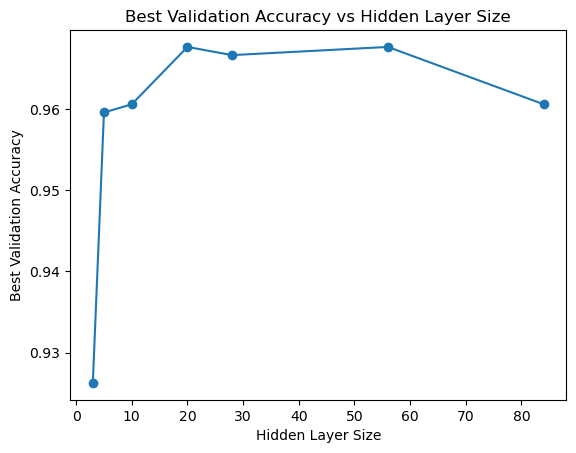

In [ ]:
import matplotlib.pyplot as plt

hidden_vals = [h[0] for h in hidden_accs]
acc_vals = [h[1] for h in hidden_accs]

plt.plot(hidden_vals, acc_vals, marker='o')
plt.xlabel("Hidden Layer Size")
plt.ylabel("Best Validation Accuracy")
plt.title("Best Validation Accuracy vs Hidden Layer Size")
plt.show()


The graph above shows the relation between hidden layer size and the best accuracy score for that layer size during grid search. <br>
It has lower values for smaller layer sizes, and decreases as size increases. It peaks at 20, and beyond that, there is no improvement with increase in model complextiy. Its also interesting to see the slight decrease in performance at 86 layer size. 

## Results

In [ ]:
print("Test accuracy of the best model", best_model.score(X_test, y_test))
print("\nBest hyperameters:", best_hyper )

Test accuracy of the best model 0.9707070707070707

Best hyperameters: {'alpha': 0.1, 'hidden_size': 20, 'max_iters': 50000, 'val_acc': 0.9676767676767677}


**We get a test accuracy of 0.9707**<br>
**Hidden layer of size 20 gives the best result**<br>
<br> 
This is the parameters for which we get the best performing model. Lower number of hidden layer nodes might be causing the model to underfit since theere is 28x28 features.<br>

The following is the training curve of the average loss against iterations. 

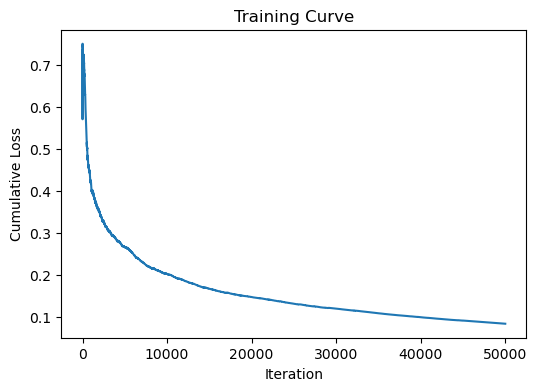

In [ ]:
loss_array = np.array(best_model.loss_history)
cumulative_avg = np.cumsum(loss_array) / np.arange(1, len(loss_array)+1)

plt.figure(figsize=(6,4))
plt.plot(cumulative_avg)
plt.xlabel("Iteration")
plt.ylabel("Cumulative Loss") #this is not prnting idk why
plt.title("Training Curve")
plt.show()


We'll print the confusion matrix to see the distribution of actual vs predicted classes

In [ ]:
print(confusion_matrix(y_test,best_model.predict(X_test).ravel() ))

[[485  11]
 [ 18 476]]


There is only (11 + 18 = 29) errors out of 990 data points, which is a good classification rate.

# Task 5

Extending the previous model to support and arbitray number of hidden layers, which is a parameter as list, which should describe the hidden layers and their sizes<br>
in fit , for forward and backward propagation, the weights are updated in loops that run through the list 'weights'.<br>
'A' stores the activation for one forward propagation and it used in the backward propagation again, to calculate the gradient<br> 
It also calculates the average loss with the l2 penalty added, every N iterations, and keeps track of it to plot it later.<br>

'lam' is lambda, the regularization parameter<br>

On every backprogapation, every weight is now being reduced by an additional amount lam/(2m)<br>

**Implementation changes**<br>
- The hidden_layers parameter is now a list specifying the number of nodes in each hidden layer.
- Foward pass - activations are computed sequentially 
- Back Propagation - Gradients and weights are calculated and updated 
- L2 regularization - Added regularization term to cross-entropy, and learning rules for weights



**Regularization**<br>
We have used L2 regularization to reduce overfitting.<br>
Regularization encourages the network to keep weights small, and  allows large weights only if they significantly reduce the original cost. The balance between minimizing the cost and keeping weights small depends on lambda. Small lambda prioritizes cost reduction, while large lambda emphasizes smaller weights.<br>
We trained and validated the model with varying degrees of lambda.

src : http://neuralnetworksanddeeplearning.com/chap3.html#overfitting_and_regularization

### Model implementationo

In [6]:
class LogisticRegressor:
    def __init__(self, alpha=0.01, max_iters=100000, threshold=1e-6, N=1000,hidden_layers=[5, 3, 2], seed=42,lam=0.001):
        self.alpha = alpha
        self.max_iters = max_iters
        self.threshold = threshold
        self.N = N
        self.hidden_layers = hidden_layers #specifies hidden layers
        self.seed = seed
        self.loss_history = []
        self.accuracy_history = []
        self.lam = lam
        self.trained = False #to be used in predict
        


    def sigmoid(self, t):
        return 1/(1 + np.exp(-t))

    #def relu(self, z):
        #return np.maximum(0, z)

    #def relu_derivative(self, z):
        #return (z > 0).astype(float)
    
    def loss_function(self, y, y_cap):
        epsilon = np.finfo(float).eps
        y_cap = np.clip(y_cap, epsilon, 1 - epsilon)
        return -(y * np.log(y_cap) + (1 - y) * np.log(1 - y_cap))
    
    def fit(self, X, Y):
        np.random.seed(self.seed)
        self.loss_history = []
        self.accuracy_history = []

        m = X.shape[0] # samples
        n = X.shape[1] # features

        weights = []
        biases = []

        self.layers = [n] + self.hidden_layers + [1]

        for i in range(len(self.layers) - 1):
            w = np.random.randn(self.layers[i+1], self.layers[i]) * 0.01
            b = np.zeros((self.layers[i+1], 1))
            weights.append(w)
            biases.append(b)

        X = np.array(X)
        Y = np.array(Y).reshape(-1, 1)


        stopping = False; loss_prev = 0; iteration = 0; acc = 0
        

        while not stopping:
            #select random data point
            
            random_data_index = np.random.choice(np.arange(m))  # pick a random index
            x = X[random_data_index].reshape(-1,1)
            y = Y[random_data_index, 0]


            #activations
            a = x
            A = [a]

            #forward pass
            for i in range(len(weights)):
                a = self.sigmoid(weights[i] @ a + biases[i])
                A.append(a)

            y_cap = A[-1] # last activation is the output, hopefully 
            
            # loss = self.loss_function(y, y_cap)
            # l2_penalty = 0.0
            # for w in weights:
            #     l2_penalty += np.sum(w**2)

            # loss = loss + (self.lam / 2.0) * l2_penalty
            # self.loss_history.append(float(loss.item()) )

            #computes loss + l2 penalty every N iterations, replacing loss calculation code above
            #total loss (plus penalty ) and accuraacy are computed every N iters
            if iteration % self.N == 0:
                total_loss = 0.0
                correct = 0
                for j in range(m):
                    x_sample = X[j].reshape(-1,1)#reshaped cause my sigmoid expects column vector
                    y_sample = Y[j, 0]

                    a_sample = x_sample
                    for w, b in zip(weights, biases):
                        a_sample = self.sigmoid(w @ a_sample + b)
                    
                    #loss between predicted and true, added to cumulative loss
                    total_loss += float(  self.loss_function(y_sample, a_sample).item()  )
                    #taking count of correct predictions
                    correct += int(a_sample.item() >= 0.5) == int(y_sample)
                
                #average loss is loss plus l2 penalty, over the whole training set
                avg_loss = total_loss / m + ( self.lam / ( 2.0 * m )) * sum(np.sum( w**2 ) for w in weights)
                avg_acc = correct / m

                #taking snapshot of loss and accuracy every N iterations
                self.loss_history.append(avg_loss)
                self.accuracy_history.append(avg_acc)    

            
            #-----back propagation-----
            deltaw = [np.zeros_like(w) for w in weights]
            deltab = [np.zeros_like(b) for b in biases]


            #updating gradients of output layer
            deltaz = y_cap - y
            deltab[-1] = deltaz
            deltaw[-1] = deltaz @ A[-2].T


            for i in reversed(range(len(weights)-1) ):
                deltaz = (weights[i+1].T @ deltaz) * (A[i+1] * (1 - A[i+1]))
                deltaw[i] = deltaz @ A[i].T
                deltab[i] = deltaz


            #update weights and biases, notice the addition of the regularization parameter lam
            for i in range(len(weights)):
                weights[i] -= self.alpha * (deltaw[i] + (self.lam / m) * weights[i])
                biases[i] -= self.alpha * deltab[i]

            # #to store accuracy per iteration
            # pred_i = 1 if y_cap >= 0.5 else 0
            # self.accuracy_history.append(1.0 if pred_i == y else 0.0)

        
            #loss_prev = loss
            iteration += 1
            if iteration >= self.max_iters:
                stopping = True

        #set weights here
        self.weights = weights
        self.biases = biases
        self.trained = True

    def predict(self,x):
        if (self.trained == False):
            raise ValueError("Not trained uyet!")
        
        a = np.array(x)
        if a.ndim == 1:
            a = a.reshape(-1, 1)
        else:
            a = a.T
        for w, b in zip(self.weights, self.biases):
            a = self.sigmoid(w @ a + b)
        Y_pred = (a >= 0.5).astype(int).flatten()
        return Y_pred
    
    def score(self, x_test, y_test):
        if (self.trained == False):
            raise ValueError("Not trained uyet!")        
        
        y_pred = self.predict(x_test)
        #running into shape issues so trying this 
        y_pred = y_pred.flatten()
        y_test = y_test.flatten()
        correct = 0
        size = len(y_test)

        for i in range(size):
            if (y_pred[i]==y_test[i]):
                correct+=1

        return correct/size
    

Figuring out what combination of learning rate, number and size of hidden layers, and regularization parameter gives the best model. Takes some time to train.

## Hyperparameter tuning and training 

### Reading data

In [7]:
data = np.load("datasets/emnist_letters_85800.npz")

x_data = data["x"]
y_data = data["y"]

c1 = 8   # example
c2 = 11  # example

#True for Ys either c1 or c2
mask = (y_data == c1) | (y_data == c2)

#select rows where the mask is true
x_binary = x_data[mask]
y_binary = y_data[mask]

# c2 is 1 and c1 is 0
y_binary = (y_binary == c2).astype(int)

#flattening images 
m = x_binary.shape[0]
X = x_binary.reshape(m,-1)
y = y_binary.reshape(-1,1)
print("X shape:",X.shape)
print("y shape:",y.shape)



#splitting X and Y into 70 percent train and 30 percent temp
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, shuffle=True)
#splitting temp into 50 percent val and 50 percent test, which is 15% of the original data
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, shuffle=True)

print("Train:", X_train.shape)
print("Validation:", X_val.shape)
print("Test:", X_test.shape)

X shape: (6600, 784)
y shape: (6600, 1)
Train: (4620, 784)
Validation: (990, 784)
Test: (990, 784)


### Model without regularization 

In [8]:
seed = 42

# grid for model with no regularization
grid_no_reg = {
    "alpha": [0.1, 0.5, 1.0],
    "max_iters": [50000, 100000],
    "hidden_layers": [[28, 10, 5], [20, 10], [10]],
    "lam": [0.0]
}
results_no_reg = []
best_no_reg = {"val_acc": -np.inf, "model": None, "params": None}

In [10]:
# Training with lambda = 0
for alpha, max_iters, hidden_layers, lam in product(
        grid_no_reg["alpha"], grid_no_reg["max_iters"], grid_no_reg["hidden_layers"], grid_no_reg["lam"]):

    model = LogisticRegressor(alpha=alpha, max_iters=max_iters, hidden_layers=hidden_layers, seed=seed, lam=lam, N=1000)
    model.fit(X_train, y_train)

    train_acc = model.score(X_train, y_train)
    val_acc   = model.score(X_val, y_val)

    row = {"alpha": alpha, "max_iters": max_iters, "hidden_layers": hidden_layers,
           "lam": lam, "train_acc": train_acc, "val_acc": val_acc}
    results_no_reg.append(row)

    if val_acc > best_no_reg["val_acc"]:
        best_no_reg.update({"val_acc": val_acc, "model": model, "params": row})

    print(f"[No Reg] alpha={alpha:<5} iters={max_iters:<6} layers={hidden_layers} lam={lam:g} "
          f"-> train={train_acc:.4f} val={val_acc:.4f}")

[No Reg] alpha=0.1   iters=50000  layers=[28, 10, 5] lam=0 -> train=0.9335 val=0.9222
[No Reg] alpha=0.1   iters=50000  layers=[20, 10] lam=0 -> train=0.9896 val=0.9687
[No Reg] alpha=0.1   iters=50000  layers=[10] lam=0 -> train=0.9803 val=0.9566
[No Reg] alpha=0.1   iters=100000 layers=[28, 10, 5] lam=0 -> train=0.9866 val=0.9475
[No Reg] alpha=0.1   iters=100000 layers=[20, 10] lam=0 -> train=0.9968 val=0.9687
[No Reg] alpha=0.1   iters=100000 layers=[10] lam=0 -> train=0.9961 val=0.9667
[No Reg] alpha=0.5   iters=50000  layers=[28, 10, 5] lam=0 -> train=0.9221 val=0.9040
[No Reg] alpha=0.5   iters=50000  layers=[20, 10] lam=0 -> train=0.8511 val=0.8485
[No Reg] alpha=0.5   iters=50000  layers=[10] lam=0 -> train=0.9452 val=0.9364
[No Reg] alpha=0.5   iters=100000 layers=[28, 10, 5] lam=0 -> train=0.9494 val=0.9394
[No Reg] alpha=0.5   iters=100000 layers=[20, 10] lam=0 -> train=0.9530 val=0.9374
[No Reg] alpha=0.5   iters=100000 layers=[10] lam=0 -> train=0.9532 val=0.9414
[No Reg]

### Model with regularization

In [11]:

# grif for model with regularization
grid_l2 = {
    "alpha": [0.1, 0.5, 1.0],
    "max_iters": [50000, 100000],
    "hidden_layers": [[28, 10, 5], [20, 10], [10]],
    "lam": [1e-4, 1e-3, 1e-2, 1.0]   # include 1 here
}
results_l2 = []
best_l2     = {"val_acc": -np.inf, "model": None, "params": None}

In [12]:
# training with diff lambdas
for alpha, max_iters, hidden_layers, lam in product(
        grid_l2["alpha"], grid_l2["max_iters"], grid_l2["hidden_layers"], grid_l2["lam"]):

    model = LogisticRegressor(alpha=alpha, max_iters=max_iters, hidden_layers=hidden_layers, seed=seed, lam=lam, N=1000)
    model.fit(X_train, y_train)

    train_acc = model.score(X_train, y_train)
    val_acc   = model.score(X_val, y_val)

    row = {"alpha": alpha, "max_iters": max_iters, "hidden_layers": hidden_layers,
           "lam": lam, "train_acc": train_acc, "val_acc": val_acc}
    results_l2.append(row)

    if val_acc > best_l2["val_acc"]:
        best_l2.update({"val_acc": val_acc, "model": model, "params": row})

    print(f"[L2] alpha={alpha:<5} iters={max_iters:<6} layers={hidden_layers} lam={lam:g} "
          f"-> train={train_acc:.4f} val={val_acc:.4f}")




[L2] alpha=0.1   iters=50000  layers=[28, 10, 5] lam=0.0001 -> train=0.9749 val=0.9626
[L2] alpha=0.1   iters=50000  layers=[28, 10, 5] lam=0.001 -> train=0.9368 val=0.9222
[L2] alpha=0.1   iters=50000  layers=[28, 10, 5] lam=0.01 -> train=0.9736 val=0.9556
[L2] alpha=0.1   iters=50000  layers=[28, 10, 5] lam=1 -> train=0.9777 val=0.9505
[L2] alpha=0.1   iters=50000  layers=[20, 10] lam=0.0001 -> train=0.9887 val=0.9697
[L2] alpha=0.1   iters=50000  layers=[20, 10] lam=0.001 -> train=0.9823 val=0.9677
[L2] alpha=0.1   iters=50000  layers=[20, 10] lam=0.01 -> train=0.9781 val=0.9667
[L2] alpha=0.1   iters=50000  layers=[20, 10] lam=1 -> train=0.9764 val=0.9616
[L2] alpha=0.1   iters=50000  layers=[10] lam=0.0001 -> train=0.9864 val=0.9505
[L2] alpha=0.1   iters=50000  layers=[10] lam=0.001 -> train=0.9823 val=0.9545
[L2] alpha=0.1   iters=50000  layers=[10] lam=0.01 -> train=0.9768 val=0.9535
[L2] alpha=0.1   iters=50000  layers=[10] lam=1 -> train=0.9825 val=0.9586
[L2] alpha=0.1   ite

C:\Users\jinur\AppData\Local\Temp\ipykernel_10600\1525250953.py:17: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-t))


[L2] alpha=1.0   iters=50000  layers=[20, 10] lam=0.0001 -> train=0.7853 val=0.8030
[L2] alpha=1.0   iters=50000  layers=[20, 10] lam=0.001 -> train=0.8723 val=0.8606
[L2] alpha=1.0   iters=50000  layers=[20, 10] lam=0.01 -> train=0.4946 val=0.5242
[L2] alpha=1.0   iters=50000  layers=[20, 10] lam=1 -> train=0.8632 val=0.8424
[L2] alpha=1.0   iters=50000  layers=[10] lam=0.0001 -> train=0.9314 val=0.9212
[L2] alpha=1.0   iters=50000  layers=[10] lam=0.001 -> train=0.9035 val=0.8929
[L2] alpha=1.0   iters=50000  layers=[10] lam=0.01 -> train=0.9080 val=0.9051
[L2] alpha=1.0   iters=50000  layers=[10] lam=1 -> train=0.8506 val=0.8646
[L2] alpha=1.0   iters=100000 layers=[28, 10, 5] lam=0.0001 -> train=0.4952 val=0.5253
[L2] alpha=1.0   iters=100000 layers=[28, 10, 5] lam=0.001 -> train=0.5056 val=0.4758
[L2] alpha=1.0   iters=100000 layers=[28, 10, 5] lam=0.01 -> train=0.5857 val=0.5596
[L2] alpha=1.0   iters=100000 layers=[28, 10, 5] lam=1 -> train=0.8400 val=0.8394
[L2] alpha=1.0   ite

In [15]:
print("best model without reg hyperparameters :", best_no_reg["params"])
print("Best model with regularization         :" , best_l2["params"])

best model without reg hyperparameters : {'alpha': 0.1, 'max_iters': 50000, 'hidden_layers': [20, 10], 'lam': 0.0, 'train_acc': 0.9896103896103896, 'val_acc': 0.9686868686868687}
Best model with regularization         : {'alpha': 0.1, 'max_iters': 100000, 'hidden_layers': [20, 10], 'lam': 0.0001, 'train_acc': 0.9974025974025974, 'val_acc': 0.9787878787878788}


Without regularization, accuracy drops from 0.9896 to 0.9686.<br>
With regularization, accuracy drop from 0.9974 to 0.9787, a much smaller drop, but definitely a higher test accuracy than the unregularized moodel.<br>
Models, with 2 layers [20,10] is better than model with 3 layers [28, 10, 5] and a single hidden layer[10]


### Training Curve

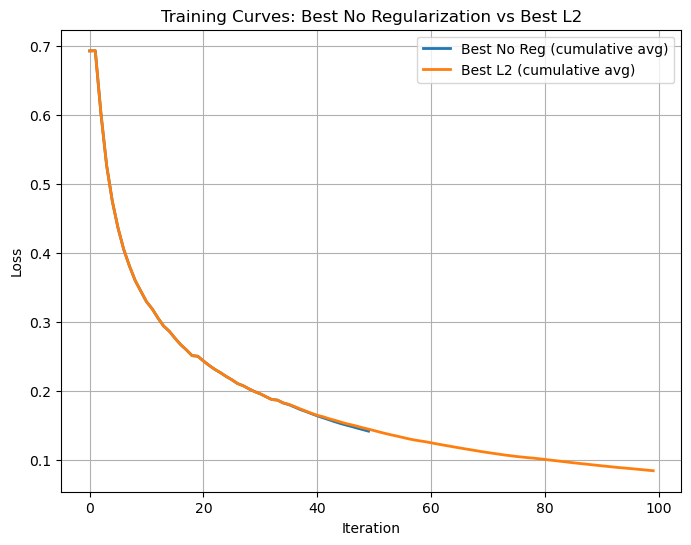

In [16]:
# Extract loss histories
loss_no = np.array(best_no_reg["model"].loss_history)
loss_l2 = np.array(best_l2["model"].loss_history)

# Compute cumulative averages
cum_no = np.cumsum(loss_no) / np.arange(1, len(loss_no)+1)
cum_l2 = np.cumsum(loss_l2) / np.arange(1, len(loss_l2)+1)

plt.figure(figsize=(8,6))

# Smoothed curves (clear trend)
plt.plot(cum_no, linewidth=2, label="Best No Reg (cumulative avg)")
plt.plot(cum_l2, linewidth=2, label="Best L2 (cumulative avg)")

plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Curves: Best No Regularization vs Best L2")
plt.grid(True)
plt.legend()
plt.show()


Models with 2 hidden layers perform better than models with 3 layers.


## Comparison with Model with 1 hidden layer

Test accuracy of the model from task 4 : 0.9707


In [ ]:
print("Confusion matrix or non "confusion_matrix(y_test,best_no_reg.predict(X_test).ravel() ))
print(confusion_matrix(y_test,best_l2.predict(X_test).ravel() ))